<a href="https://colab.research.google.com/github/IciaCarroBarallobre/AdventOfCode/blob/main/notebooks/Dataset_ETL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#  ETL: Extract, transform and Load





## Imports

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
#### HYPERPARAM
ROOT_DIR, DATASET = '/content/drive/My Drive/TFG/data/datasets/', 'subrolldataset/'
DATASET_NAME = "/info.csv"
OVERLAP = True  # CROP - hyperparam
SUB = True # hyperparam - NAME

####### CONSTANTS
RED, GREEN, BLUE, = [1,0,0], [0,1,0], [0,0,1]
BLACK, WHITE = [0,0,0], [1,1,1]
YELLOW = [1,1,0]

In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os   
import math 
import time
import torch 
from torchvision import  transforms 
from PIL import Image 
from scipy.ndimage.measurements import label
from PIL import Image 

## Aux Functions

In [9]:
def print_bar(now, maximum, max_length = 20):
    done = now/maximum
    print("\r"+round(done*max_length)*"█"+round(max_length*(1-done))*"░"+" "+str(round(done*100,2))+"% ", end='')

In [10]:
def get_mask_indexes(tensor):  
  return ((tensor == torch.Tensor([1,1,1])).nonzero()[:,0:2])

def get_mask_max_y(indexes):
  return (indexes)[:,0].max().item()

def get_mask_min_y(indexes):
  return (indexes)[:,0].min().item()

In [11]:
##################   Position of extension   #############################
# Search within a string if there are any of the extensions in the list
# and return its position else return -1
##########################################################################

def pos_ext(ext):
  for e in ['bmp', 'png', 'jpeg', 'tif', 'jpg']:
    pext = ext.find(e)
    if pext > -1:
      return pext
  return -1

def new_filename(filename,i):
  point, pext = filename.index("."), pos_ext(filename[:point]) 
  if pext > -1:
    return filename[:pext]+ "_" + str(i) + filename[pext:point]+ filename[point:]
  else:
    return filename[:point]+ "_" + str(i) + filename[point:]

In [12]:
##################   Position of extension   #############################
# Transform RGB PIL Image to tensor - Image PIL: (RGB x height x width) 
# Tensor: (width, height, RGB). 
##########################################################################

def image_to_tensor(root):
  toTensor = transforms.ToTensor()
  image = Image.open(root).convert('RGB')   
  return toTensor(image).permute(1,2,0) 

In [13]:
def create_mask(data, color_to_detect):
  return  (data[:,:,0] == color_to_detect[0] ) & (data[:,:,1] == color_to_detect[1]) & (data[:,:,2] == color_to_detect[2])

def yellow_to_doubt(npimag):
  mask = create_mask(npimag, YELLOW)
  npimag[:,:,:3] [mask] = [0,0,0]
  return npimag

## Dataset a csv 

Create a csv with the images, roots and labels (CME, DRT, SRD, DME) for the following Dataset function: 

 `OCTDataset.__getitem __(self,idx)`



In [14]:
def subname_to_name(filename):
  return filename[:filename.index("_")]+filename[filename.index("."):]

def cirrus_or_spectralis(filename, sub):
  cirrus = [str(i)+"."+ext for i in range(1,639) for ext in ['bmp', 'png', 'jpeg', 'tif', 'jpg']]
  if sub:
    return "CIRRUS" if subname_to_name(filename) in cirrus  else "SPECTRALIS"
  else:
    return "CIRRUS" if filename in cirrus else "SPECTRALIS"

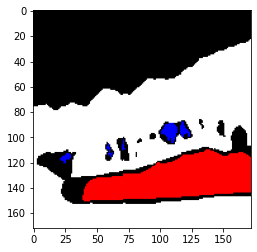

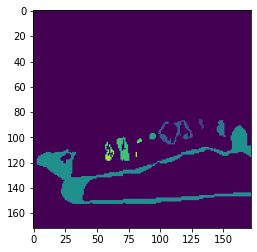

0.381


In [15]:
def doubt_percentage(np_image, verbose = 0):
  data = np_image.copy()
  mask = create_mask(data, RED) | create_mask(data, GREEN) | create_mask(data, BLUE) 
  data[:,:,:3] [mask] = [1, 1, 1]

  # Count labeled pixeles
  mask_labeled_pixels = create_mask(data, (1, 1, 1))
  labeled_pixeles = np.sum(mask_labeled_pixels)
  
  data = 1 - data # Invertir

  binary = data[:,:,0].astype(dtype=np.int32) # Only grayscale
  structure = np.ones((3, 3))# Vecindad 8

  labeled_array, _ = label(binary, structure=structure)
  labeled_array[:,:][labeled_array[:,:]==1] = 0

  if DATASET == "rolldataset/":
    zone1 =  labeled_array[0, labeled_array.shape[1]-1]
    labeled_array[:,:][labeled_array[:,:]==zone1] = 0
  elif DATASET == "subdataset/" or DATASET == "subrolldataset/":
    right, bottom = labeled_array.shape[1]-1, labeled_array.shape[0]-1

    zone1 =  labeled_array[0, right]
    zone2 =  labeled_array[bottom, right]
    zone3 =  labeled_array[bottom, 0]

    labeled_array[:,:][labeled_array[:,:]==zone1] = 0
    labeled_array[:,:][labeled_array[:,:]==zone2] = 0    
    labeled_array[:,:][labeled_array[:,:]==zone3] = 0       

  if verbose:
    plt.imshow(labeled_array)
    plt.show()

  doubt = np.sum(labeled_array[labeled_array>0]) 
  return  np.round(doubt/ (labeled_pixeles+doubt),3)


image = Image.open(ROOT_DIR+ "/subrolldataset/LABELS/8775_2.png".replace(".","")+".png").convert('RGB')
toTensor = transforms.ToTensor()
tensor = toTensor(image).permute(1,2,0)
np_image = np.round(tensor.numpy()) # sometimes 1 is 0.9+ 

plt.imshow(np_image)
plt.show()

print(doubt_percentage(np_image, verbose = 1))    

In [16]:
######################   Precondition   #############################
# We must have 2 folders: one that contains the originals images 
# and other that contains the labels images of the originals. 
# Labels name is the same of original +".png" 
# Example: original.jpg (Original) -> originaljpg.png (Label)
######################################################################

def info_to_csv(root_dataset, sub= SUB,original_folder="ORIGINALS/", labels_folder="LABELS/", dataset_name = "/info.csv"):
  toTensor = transforms.ToTensor()
  df = pd.DataFrame({})
  max = len(os.listdir(root_dataset + original_folder))
  now = 0
  for filename in os.listdir(root_dataset + original_folder): 
    now = now +1

    # Image to numpy array
    root_label = root_dataset + labels_folder + filename.replace(".","")+".png"
    image = Image.open(root_label).convert('RGB')
    tensor = toTensor(image).permute(1,2,0)
    np_image = np.round(tensor.numpy()) # sometimes 1 is 0.9+ 

    # Buscar si hay azul/rojo/verde en las imagenes para etiquetarlas
    DRT, SRD, CME = 0,0,0 
    if(np.logical_and.reduce(np_image == RED, 2).any()): DRT = 1
    if(np.logical_and.reduce(np_image == GREEN, 2).any()): SRD = 1
    if(np.logical_and.reduce(np_image == BLUE, 2).any()): CME = 1
    doubt = doubt_percentage(np_image)
    DME =   1 if( DRT | SRD| CME| (doubt > 0) ) else 0

    row = {'device': cirrus_or_spectralis(filename, sub),
           'name': filename,
           'root': root_dataset+original_folder+filename,
           'root_label':root_label, 
           'DRT': DRT, 'SRD': SRD, 'CME': CME, 'DME': DME,
           'id': subname_to_name(filename) if sub else filename,
           'doubt_percentage':  doubt}   

    print_bar(now,max)
    df = df.append(row, ignore_index = True)
  
  df.to_csv(root_dataset+dataset_name, index=False)

In [17]:
info_to_csv(ROOT_DIR+DATASET, labels_folder="LABELS2/", dataset_name = "/info_labels2.csv")

████████████████████ 100.0% 

## Crop 

### Get centers with overlap


##### Explicacion


![Exemplo](https://drive.google.com/uc?id=1YPUtf1OxnzQqsAGJGcR3T6stPL9_2abh)


##### Codigo

In [ ]:
# Dependencias:
##  - Los path como parametros acabarlos en / 
##  - Cuando se quiera rodar una imagen debe tener su homonima en mask
##  - Cada una se aloja en: MASKS; ORIGINALS; LABELS respectivamente.
##  - La mascara y la label tienen como filename: el de la original+extencion+.png
DEBUG = 0 # Test

def get_squares_centers_overlap(width, height):
  square_number = math.ceil(width / height) 
  mod = True if width  % height else False

  cuadrado_sobrante_fora = height * square_number - width
  cadrado_sobrante_dentro = height - cuadrado_sobrante_fora
  x = cuadrado_sobrante_fora/ (square_number -1)
  desplazamento =[ -i * x for i in range(square_number)]
  if mod: 
    centers = list(range(math.floor(height/2), width+height, height))
    centers = [math.floor(x + y) for x, y in zip(centers, desplazamento)]
  else:
    centers = list(range(math.floor(height/2), width, height))
  return centers

### Get centers without overlap



#### Explicacion 


Cada mostra sería unha porción cadrada dunha imaxe OCT. 

![Exemplo](https://drive.google.com/uc?id=1Qar7jdd9xK3D6o_7qpujXab2aMWlgVkO)

---


**Ventaxas**:

*   Compensamos o problema da relación de aspecto de Spectralis vs Cirrus e podemos seguir empregando transfer learning.
*   Estratexia  sinxela de implementar 
*   Incrementaríamos moitísimo o número virtual de mostras que temos 
*   Os datasets deberían estar equilibrados para mellores resultados entre clase positiva e negativa. Obtemos un número maior de mostras de cada clase coas que será máis sinxelo balancear o dataset.
---
**Algoritmo**

<img src="https://drive.google.com/uc?id=1HiMtMXQZ6URsRjuEO1ilDR3sHc-39mWy"  height="250" />


---


#### Codigo

In [ ]:
# Dependencias:
##  - Los path como parametros acabarlos en / 
##  - Cuando se quiera rodar una imagen debe tener su homonima en mask
##  - Cada una se aloja en: MASKS; ORIGINALS; LABELS respectivamente.
##  - La mascara y la label tienen como filename: el de la original+extencion+.png
DEBUG = 0 # Test

# Obtener los centros de los posibles cuadrados de la imagen
def get_squares_centers(width, height):
  square_number = math.ceil(width / height) 
  cuadrado_sobrante_fora = height * square_number - width
  cadrado_sobrante_dentro = height - cuadrado_sobrante_fora
  desplazamento = math.floor(cadrado_sobrante_dentro/2 )
  if DEBUG > 0:
    print("Square number: ",square_number)
    print("Espazo sen coller: ",cadrado_sobrante_dentro)
    print("Desplazamento: ",desplazamento)

  return list(range(math.floor(height/2)+ desplazamento, width, height))
  

### Crop

In [ ]:
# Cropear las imagenes en cuadrados
def crop_image_in_square(root, filename, save_root): 
  
  label_filename = filename.replace(".","")+".png"

  originalroot = root + "ORIGINALS/" + filename
  maskroot = root + "MASKS/" + label_filename
  labelroot =  root +"LABELS/"+label_filename 

  tensor = image_to_tensor(maskroot)
  idx = get_mask_indexes(tensor)

  top, bottom = get_mask_min_y(idx), get_mask_max_y(idx)
  height = bottom - top
  width = int(tensor.size(1))  
  if OVERLAP:
    centers = get_squares_centers_overlap(width, height)
  else:
    centers = get_squares_centers(width,height)

  if DEBUG > 0:
    print("Size: ", width)
    print("Top ", top, " bottom ", bottom)
    print("Centers: ", centers)

  image = Image.open(originalroot).convert('RGB')  
  mask = Image.open(maskroot).convert('RGB')
  label = Image.open(labelroot).convert('RGB')

  for i in range(len(centers)):    
    left, right = centers[i] - height/2, centers[i] + height/2
    size = (left, top, right, bottom)
    
    image_cropped = image.crop(size)
    image_cropped.save(save_root + "SUBORIGINALS/" + new_filename(filename,i+1))
    
    label_cropped = label.crop(size)
    label_cropped.save(save_root + "SUBLABELS/" + new_filename(label_filename,i+1))


In [ ]:
now, max = 0, len(os.listdir(ROOT_DIR + DATASET+"ORIGINALS/"))
root = ROOT_DIR + DATASET
save_root = root

for filename in os.listdir(ROOT_DIR + DATASET+"ORIGINALS/"):
  now = now + 1
  print_bar(now,max)
  crop_image_in_square(root, filename, save_root)

## Roll images

En esta parte del código se realizan lo siguiente:

1.   Aplanar la imagenes basandose en su máscara
2.   Recortar arriba y abajo lo sobrante



In [ ]:
# Inputs: indexes of (y,x) image white pixeles value, max white y
# Outputs: [x, distance]
def get_distance(idw,max_y):
  df= pd.DataFrame(idw.numpy(), columns = ["max_y","x"])
  df = df.groupby("x")["max_y"].max().to_frame()
  df['x'] = df.index
  df['distance'] =  max_y -df['max_y']
  df.drop(inplace=True, columns=["max_y"])
  return df.values.tolist()

## Rodar  las columnas del tensor x distancias
def roll(tensor, distance):
  range_distance = range(len(distance[:,0]))
  for i in range_distance:
    x, dist = int(distance[i,0]), int(distance[i,1])
    tensor[:, x] = tensor[:, x].roll(shifts = dist, dims=0)
  return tensor   

# Cropear arriba y abajo
def crop(tensor,min,max):
  return tensor[ min:max,:]

In [ ]:
def roll_and_crop(tensors, mask_tensor):
  idx = get_mask_indexes(mask_tensor)
  max_y= get_mask_max_y(idx)
  distance = torch.Tensor(get_distance(idx,max_y))
  mask_tensor = roll(mask_tensor, distance)
  idx = get_mask_indexes(mask_tensor)
  min_y =  get_mask_min_y(idx)
  mask_tensor = crop(mask_tensor,min_y,max_y)
  for key in tensors:  
    tensors[key] = crop(roll(tensors[key], distance),min_y,max_y)

  return tensors, mask_tensor

In [ ]:
# Dependencias:
##  - Los path como parametros acabarlos en / 
##  - Cuando se quiera rodar una imagen debe tener su homonima en mask
##  - Cada una se aloja en: MASKS; ORIGINALS; LABELS respectivamente.
##  - La mascara y la label tienen como filename: el de la original+extencion+.png

def image_preprocess(root, filename, save_root, labels = True):

  mask_label_filename = filename.replace(".","")+".png" 
  original_root = root + "ORIGINALS/"+ filename
  mask_root = root + "MASKS/"+mask_label_filename  
  labels_path =  root +"LABELS/"+mask_label_filename if labels else None

  original_tensor = image_to_tensor(original_root)
  mask_tensor = image_to_tensor(mask_root)

  tensors = {"ORIGINALS":original_tensor}
  if labels:
    label_tensor = image_to_tensor(labels_path)
    tensors["LABELS"] = label_tensor

  tensor_list, mask = roll_and_crop(tensors, mask_tensor)

  mask = transforms.ToPILImage()(mask.permute(2,0,1) )
  save_image_root = save_root +"MASKS/"+ mask_label_filename
  mask.save(save_image_root)

  for key in tensors:  
    image = transforms.ToPILImage()(tensors[key].permute(2,0,1) )
    save_image_root = save_root+"/"+key+"/"
    if key == "ORIGINALS": 
      save_image_root = save_image_root + filename
    else:
      save_image_root = save_image_root + mask_label_filename
    image.save(save_image_root)

In [ ]:
%%time
max, now = len(os.listdir(ROOT_DIR + DATASET  + "ORIGINALS/")), 0
root, folder = ROOT_DIR+DATASET, "ORIGINALS/"
for fichero in os.listdir(root+folder):
  now = now +1
  image_preprocess(root, fichero, ROOT_DIR+"rolldataset/")
  print_bar(now, max)

## Yellow to doubt

In [ ]:
def numpy_load_image(root):
  toTensor = transforms.ToTensor()
  tensor = toTensor(Image.open(root).convert('RGB')).permute(1,2,0)
  return np.round(tensor.numpy())

In [ ]:
max, now = len(os.listdir(ROOT_DIR + DATASET  + "ORIGINALS/")), 0

for filename in os.listdir(ROOT_DIR + DATASET  + "ORIGINALS/"): 
  now = now +1

  np_image = numpy_load_image(ROOT_DIR + DATASET + "LABELS/" + filename.replace(".","")+".png")
  np_image = yellow_to_doubt(np_image)

  pil_image = transforms.ToPILImage()(torch.tensor(np_image).permute(2,0,1))
  pil_image.save(ROOT_DIR+DATASET  + "YELLOW/" + filename.replace(".","")+".png")
  
  print_bar(now, max)


In [ ]:
now = 0
for filename in os.listdir(ROOT_DIR + DATASET  + "YELLOW/"): 
  now = now +1
print(now)

## Split test

In [ ]:
from sklearn.model_selection import train_test_split

size = 0.2
root = ROOT_DIR + DATASET + DATASET_NAME

df  = pd.read_csv(root)
df ["test_CME"]  = False 
df ["test_DME"]  = False
df ["test_SRD"]  = False
df ["test_DRT"]  = False

spectralis = df.copy() [df["device"] == "SPECTRALIS"]

In [ ]:
for enfermidade in ["CME","DRT","DME", "SRD"]:

  df_ids = spectralis.groupby(["id"]).sum()[enfermidade].to_frame()
  positive = df_ids[df_ids[enfermidade] > 0]
  negative = df_ids[df_ids[enfermidade] == 0]

  #Positive proportion
  _, positive_test_ids = train_test_split(list(positive.index), test_size = size )
  _, negative_test_ids = train_test_split(list(negative.index), test_size = size )
  test_ids =  negative_test_ids + positive_test_ids
  df["test_"+enfermidade]  = df.id.isin(test_ids)

df.to_csv(root, index=False)

In [19]:
root = ROOT_DIR + DATASET + "test.csv"
root2 = ROOT_DIR + DATASET + "./info.csv"

df  = pd.read_csv(root)
df = df[["root",'test_CME', 'test_DME', 'test_SRD', 'test_DRT']]

df_labels2  = pd.read_csv(root2)
df_labels2 = df_labels2.merge(df, on="root", how ="left")
df_labels2.to_csv(root2, index=False)